REINFORCE vs with baseline
  run 20 done
  run 40 done
  run 60 done
  run 80 done
  run 100 done
  run 20 done
  run 40 done
  run 60 done
  run 80 done
  run 100 done


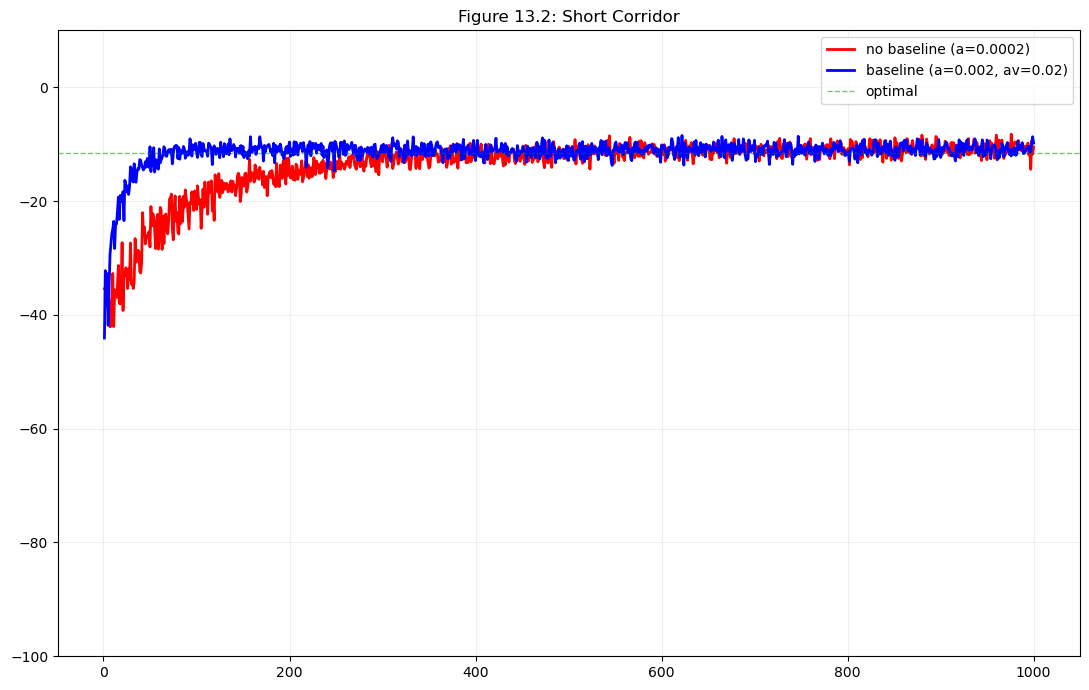

done


In [5]:
# Niveen Abdul-Mohsen (bvn9ad)
# Reinforcement Learning (CS 4771) - Figure 13.2 REINFORCE vs REINFORCE with Baseline
# This is the code for the right graph of Figure 13.2 in Sutton and Barto's RL textbook
# i used numpy for numerical operations and matplotlib for plotting

import numpy as np
import matplotlib.pyplot as plt

class SimpleCorridorEnv:
    """
    Simple corridor gridworld with state 1 having reversed action effects.
    
    States: 0 (start), 1, 2, 3 (terminal)
    Normal state mechanics: right increases state, left decreases
    State 1 exception: right decreases, left increases (asymmetry!)
    """
    
    def __init__(self):
        self.loc = 0
    
    def reset(self):
        self.loc = 0
    
    def step(self, action):
        """action: 0=left, 1=right. Returns (reward, done)."""
        
        # normal states
        if self.loc == 0 or self.loc == 2:
            if action == 1:
                self.loc += 1
            else:
                self.loc = max(0, self.loc - 1)
        
        # state 1 is weird (actions reversed)
        elif self.loc == 1:
            if action == 1:  # right goes left
                self.loc = 0
            else:  # left goes right
                self.loc = 2
        
        if self.loc == 3:
            return 0, True
        else:
            return -1, False
        
class PGWithMaybeBaseline:
    """REINFORCE with optional baseline value."""
    
    def __init__(self, alpha_policy, gamma, alpha_value=None):
        self.theta = np.array([-1.47, 1.47])
        self.baseline = 0.0
        
        self.alpha_policy = alpha_policy
        self.gamma = gamma
        self.alpha_value = alpha_value
        self.use_baseline = (alpha_value is not None)
        
        # trajectory storage
        self.ep_rewards = []
        self.ep_actions = []
    
    def get_policy(self):
        """softmax over action preferences (with exploration floor)."""
        h = self.theta  # preferences
        h = h - np.max(h)  # prevent overflow
        probs = np.exp(h) / np.sum(np.exp(h))
        
        # make sure we explore
        eps = 0.05
        worst_idx = np.argmin(probs)
        if probs[worst_idx] < eps:
            probs = (1 - eps) * probs / np.sum(probs)
            probs[worst_idx] = eps
        
        return probs
    
    def pick_action(self, prev_reward):
        """sample from policy, record reward."""
        if prev_reward is not None:
            self.ep_rewards.append(prev_reward)
        
        p = self.get_policy()
        a = 1 if np.random.random() < p[1] else 0
        self.ep_actions.append(a)
        return a
    
    def finish_episode(self, final_reward):
        """compute returns and update params."""
        self.ep_rewards.append(final_reward)
        
        # backward returns
        T = len(self.ep_rewards)
        G = np.zeros(T)
        g = 0
        for t in range(T - 1, -1, -1):
            g = self.ep_rewards[t] + self.gamma * g
            G[t] = g
        
        # updates
        gamma_power = 1.0
        for t in range(T):
            a_t = self.ep_actions[t]
            g_t = G[t]
            
            p = self.get_policy()
            
            # score function (from Sutton & Barto)
            score = np.zeros(2)
            if a_t == 0:
                score[0] = 1 - p[0]
                score[1] = -p[1]
            else:
                score[0] = -p[0]
                score[1] = 1 - p[1]
            
            if self.use_baseline:
                adv = g_t - self.baseline
                # update baseline
                self.baseline += self.alpha_value * gamma_power * adv
                # update policy
                self.theta += self.alpha_policy * gamma_power * adv * score
            else:
                self.theta += self.alpha_policy * gamma_power * g_t * score
            
            gamma_power *= self.gamma
        
        self.ep_rewards = []
        self.ep_actions = []

def train_one_run(num_episodes, agent):
    """train agent for one run, return episode returns."""
    env = SimpleCorridorEnv()
    returns = np.zeros(num_episodes)
    
    for ep in range(num_episodes):
        env.reset()
        total_r = 0
        r = None
        
        while True:
            a = agent.pick_action(r)
            r, done = env.step(a)
            total_r += r
            
            if done:
                agent.finish_episode(r)
                break
        
        returns[ep] = total_r
    
    return returns

def repeat_runs(num_episodes, num_runs, make_agent_fn):
    """run multiple times, average results."""
    all_returns = np.zeros((num_runs, num_episodes))
    
    for i in range(num_runs):
        agent = make_agent_fn()
        all_returns[i] = train_one_run(num_episodes, agent)
        
        if (i + 1) % 20 == 0:
            print(f"  run {i + 1} done")
    
    return all_returns



# run experiments and plot results
N_EPISODES = 1000
N_RUNS = 100

print("="*50)
print("REINFORCE vs with baseline")
print("="*50)

# no baseline version
a1 = 2e-4

def make_v1():
    return PGWithMaybeBaseline(alpha_policy=a1, gamma=1.0, alpha_value=None)

res1 = repeat_runs(N_EPISODES, N_RUNS, make_v1)
mean1 = res1.mean(axis=0)

# with baseline version
a2 = 2e-3
av2 = 2e-2

def make_v2():
    return PGWithMaybeBaseline(alpha_policy=a2, gamma=1.0, alpha_value=av2)

res2 = repeat_runs(N_EPISODES, N_RUNS, make_v2)
mean2 = res2.mean(axis=0)

fig, ax = plt.subplots(figsize=(11, 7))

ep_axis = np.arange(1, N_EPISODES + 1)

ax.plot(ep_axis, mean1, 'r-', linewidth=2, label=f'no baseline (a={a1})')
ax.plot(ep_axis, mean2, 'b-', linewidth=2, label=f'baseline (a={a2}, av={av2})')
ax.axhline(-11.6, color='green', linestyle='--', linewidth=1, alpha=0.5, label='optimal')

ax.set_title('Figure 13.2: Short Corridor')
ax.set_ylim(-100, 10)
ax.grid(True, alpha=0.2)
ax.legend()

plt.tight_layout()
plt.show()

print("done")
